In [17]:
!pip install yfinance scikit-learn matplotlib seaborn tensorflow scikeras --quiet

In [18]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler


In [45]:
# Define stock symbols
stock_symbols = ['AAPL', 'TSLA', 'MSFT', 'NVDA', 'COALINDIA.NS', 'INFY.NS']
interval = '1m'
lookback_minutes = 60
window_size = 5
future_steps = 1
error = 0.001


In [20]:
def fetch_stock_data(symbols, interval='1m', period='5d'):  # from '1d' → '5d'
    data = {}
    for symbol in symbols:
        print(f"Fetching {symbol}...")
        try:
            df = yf.download(tickers=symbol, interval=interval, period=period, progress=False)
            if not df.empty:
                df.dropna(inplace=True)
                data[symbol] = df
        except Exception as e:
            print(f"Error fetching {symbol}: {e}")
    return data


In [21]:
def create_dataset(series, window_size=5):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

def preprocess_for_lstm(df, window_size=5):
    close_prices = df['Close'].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(close_prices)
    X, y = create_dataset(scaled, window_size)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y, scaler


In [46]:
def build_model(units=50, dropout=0.2, window_size=5, learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=units, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

import random

def tune_model_manual(X, y, window_size):
    best_loss = float('inf')
    best_model = None
    best_params = None

    param_grid = {
        "units": [16, 32, 64],
        "dropout": [0.1, 0.2, 0.3],
        "learning_rate": [1e-2, 1e-3, 1e-4],
        "batch_size": [8, 16, 32]
    }

    print(" Manually tuning hyperparameters...")

    for _ in range(5):  # Try 5 random combos
        units = random.choice(param_grid["units"])
        dropout = random.choice(param_grid["dropout"])
        learning_rate = random.choice(param_grid["learning_rate"])
        batch_size = random.choice(param_grid["batch_size"])

        model = Sequential()
        model.add(LSTM(units=units, input_shape=(window_size, 1)))
        model.add(Dropout(dropout))
        model.add(Dense(1))
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')

        history = model.fit(X, y, epochs=50, batch_size=batch_size, verbose=0)

        loss = history.history['loss'][-1]

        if loss < best_loss:
            best_loss = loss
            best_model = model
            best_params = {
                "units": units,
                "dropout": dropout,
                "learning_rate": learning_rate,
                "batch_size": batch_size
            }

    print(" Best manual params:", best_params)
    return best_model



In [47]:
def detect_volume_anomalies(df, threshold=0.3):
    # Ensure Volume is a Series
    vol = df['Volume']
    if isinstance(vol, pd.DataFrame):
        vol = vol.iloc[:, 0]  # Take first column if it's a DataFrame

    vol = vol.astype(float)
    vol_change = vol.pct_change().fillna(0)

    # Filter and return timestamp index where % change exceeds threshold
    mask = np.abs(vol_change) > threshold
    anomaly_idx = df.index[mask]
    return anomaly_idx



In [39]:
def detect_moving_average_anomalies(df, short_window=5, long_window=20):
    df = df.copy()
    df['SMA_short'] = df['Close'].rolling(window=short_window).mean()
    df['SMA_long'] = df['Close'].rolling(window=long_window).mean()
    df['Signal'] = 0
    df['Signal'][short_window:] = np.where(
        df['SMA_short'][short_window:] > df['SMA_long'][short_window:], 1, -1)
    df['Crossover'] = df['Signal'].diff()

    #  Return only timestamp indexes
    bullish_cross = df[df['Crossover'] == 2].index
    bearish_cross = df[df['Crossover'] == -2].index

    return bullish_cross, bearish_cross, df


In [50]:
def detect_anomalies(stock_data, stock_symbols, window_size=5):
    for symbol in stock_symbols:
        print(f"\n Processing: {symbol}")
        df = stock_data.get(symbol)
        if df is None or len(df) < window_size + 1:
            print("Insufficient data. Skipping...")
            continue

        # Preprocess
        X, y, scaler = preprocess_for_lstm(df, window_size)
        model = tune_model_manual(X, y, window_size)

        # Predict
        y_pred = model.predict(X)
        y_true = y.reshape(-1, 1)
        y_pred = y_pred.reshape(-1, 1)
        y_true_inv = scaler.inverse_transform(y_true)
        y_pred_inv = scaler.inverse_transform(y_pred)

        # LSTM error
        error = np.abs((y_true_inv - y_pred_inv) / y_true_inv)

        #  Dynamic threshold
        error_threshold = np.mean(error) + 2 * np.std(error)
        print(f" Dynamic threshold set to {error_threshold:.4f}")
        print(f" Max error: {np.max(error):.4f}, Mean error: {np.mean(error):.4f}, Std Dev: {np.std(error):.4f}")

        #  Plot histogram of errors
        plt.figure(figsize=(8, 4))
        plt.hist(error.flatten(), bins=50, color='purple', alpha=0.7)
        plt.title(f"Prediction Error Distribution - {symbol}")
        plt.xlabel("Relative Error")
        plt.ylabel("Frequency")
        plt.grid(True)
        plt.show()

        anomalies = error > error_threshold
        anomaly_times = df.index[window_size:][anomalies.flatten()]
        anomaly_prices = y_true_inv[anomalies.flatten()].flatten()

        anomaly_log = pd.DataFrame({
            'Timestamp': anomaly_times,
            'Actual Price': anomaly_prices,
            'Predicted Price': y_pred_inv[anomalies.flatten()].flatten(),
            'Symbol': symbol
        })

        anomaly_log.to_csv(f"{symbol}_LSTM_anomalies.csv", index=False)
        print(f" Exported {len(anomaly_log)} LSTM anomalies to {symbol}_LSTM_anomalies.csv")

        # Plot LSTM result
        plt.figure(figsize=(12, 4))
        plt.plot(df.index[window_size:], y_true_inv, label='True')
        plt.plot(df.index[window_size:], y_pred_inv, label='Predicted')
        plt.scatter(anomaly_times, anomaly_prices, color='red', marker='x', label='LSTM Anomaly')
        plt.title(f"LSTM Anomaly Detection: {symbol}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Volume anomaly visualization
        volume_anomalies = detect_volume_anomalies(df)
        plt.figure(figsize=(12, 4))
        plt.plot(df.index, df['Volume'], label='Volume')
        plt.scatter(volume_anomalies, df.loc[volume_anomalies]['Volume'], color='orange', marker='o', label='Vol Anomaly')
        plt.title(f"Volume Anomalies: {symbol}")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Moving average crossovers
        bullish_idx, bearish_idx, df_ma = detect_moving_average_anomalies(df)
        if not isinstance(bullish_idx, pd.Index): bullish_idx = pd.Index(bullish_idx)
        if not isinstance(bearish_idx, pd.Index): bearish_idx = pd.Index(bearish_idx)

        plt.figure(figsize=(12, 4))
        plt.plot(df_ma.index, df_ma['Close'], label='Price')
        plt.plot(df_ma.index, df_ma['SMA_short'], label='SMA5')
        plt.plot(df_ma.index, df_ma['SMA_long'], label='SMA20')
        plt.scatter(bullish_idx, df_ma.loc[bullish_idx]['Close'], marker='^', color='green', label='Bullish Cross')
        plt.scatter(bearish_idx, df_ma.loc[bearish_idx]['Close'], marker='v', color='red', label='Bearish Cross')
        plt.title(f"MA Crossovers: {symbol}")
        plt.legend()
        plt.grid(True)
        plt.show()

        #  Combined anomaly: LSTM + MA crossover
        combined_ma_idx = bullish_idx.union(bearish_idx)
        combined_anomalies = set(anomaly_times).intersection(set(combined_ma_idx))
        confirmed_df = anomaly_log[anomaly_log['Timestamp'].isin(combined_anomalies)]

        # Save combined
        confirmed_df.to_csv(f"{symbol}_confirmed_anomalies.csv", index=False)
        print(f" {len(confirmed_df)} combined anomalies saved to {symbol}_confirmed_anomalies.csv")

        if not confirmed_df.empty:
            print(confirmed_df[['Timestamp', 'Actual Price', 'Predicted Price']].head())



 Processing: AAPL
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 16}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
 Dynamic threshold set to 0.0017
 Max error: 0.0026, Mean error: 0.0007, Std Dev: 0.0005


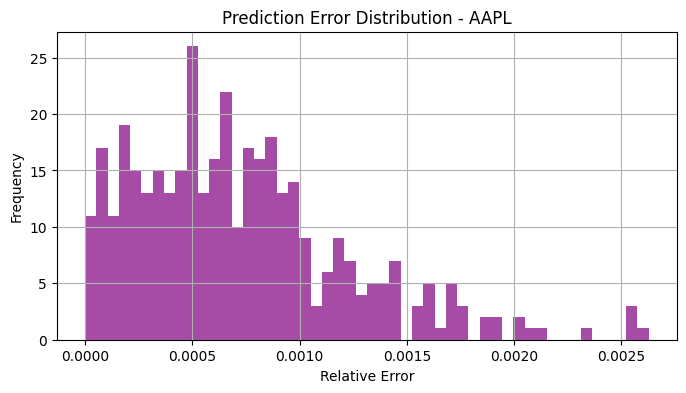

 Exported 16 LSTM anomalies to AAPL_LSTM_anomalies.csv


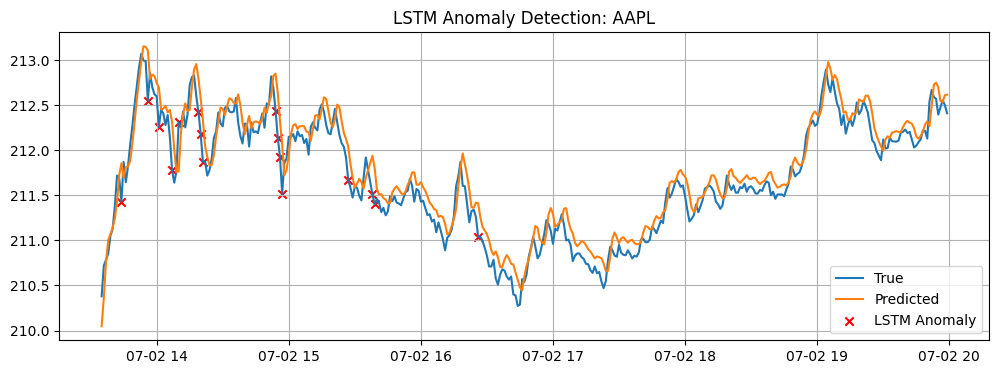

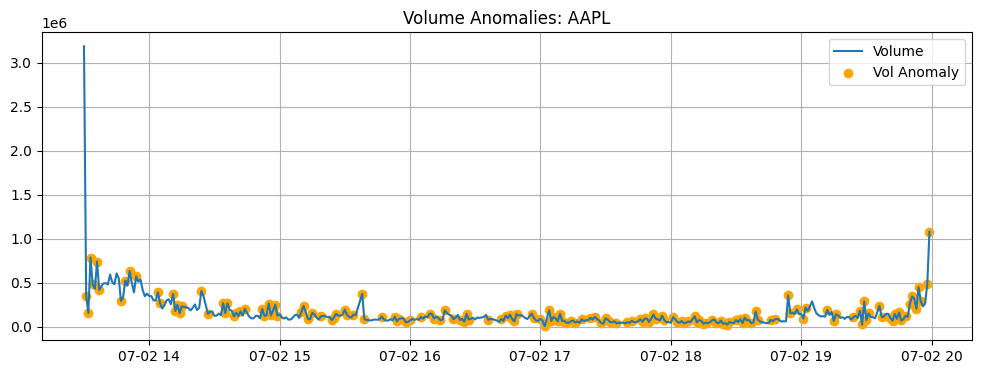

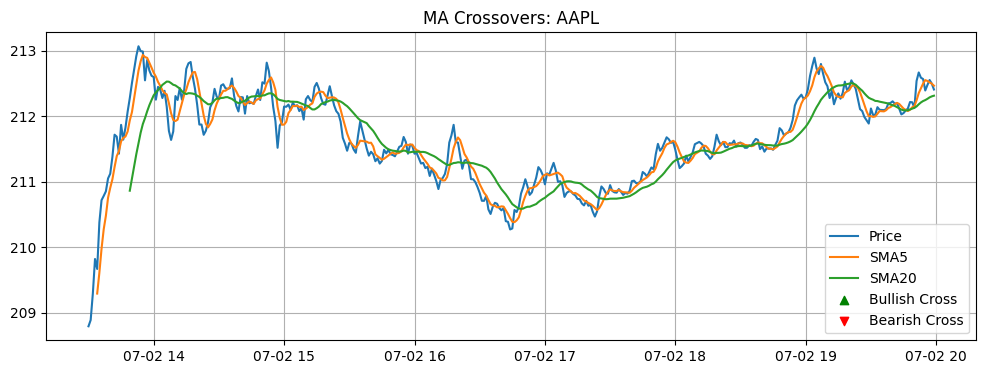

 0 combined anomalies saved to AAPL_confirmed_anomalies.csv

 Processing: TSLA
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 64, 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 16}
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
 Dynamic threshold set to 0.0035
 Max error: 0.0060, Mean error: 0.0014, Std Dev: 0.0010


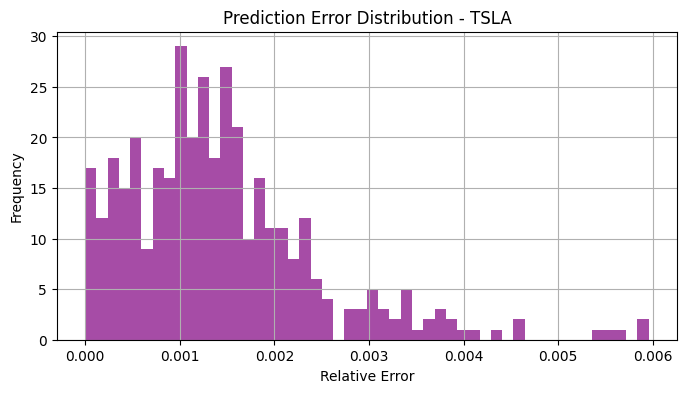

 Exported 18 LSTM anomalies to TSLA_LSTM_anomalies.csv


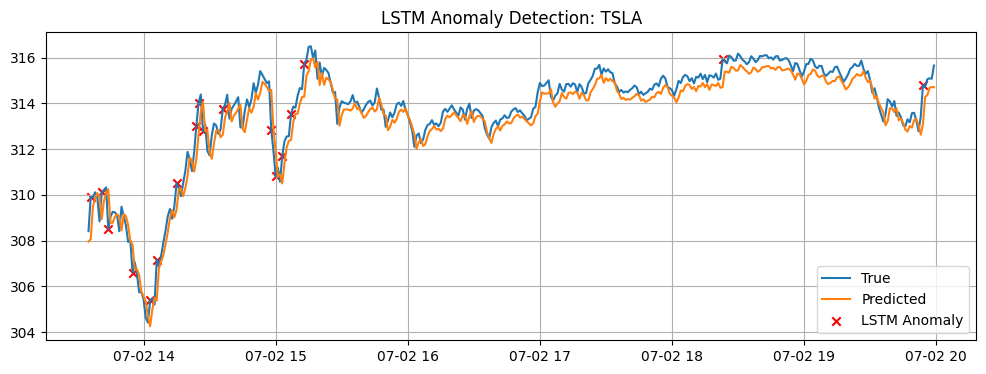

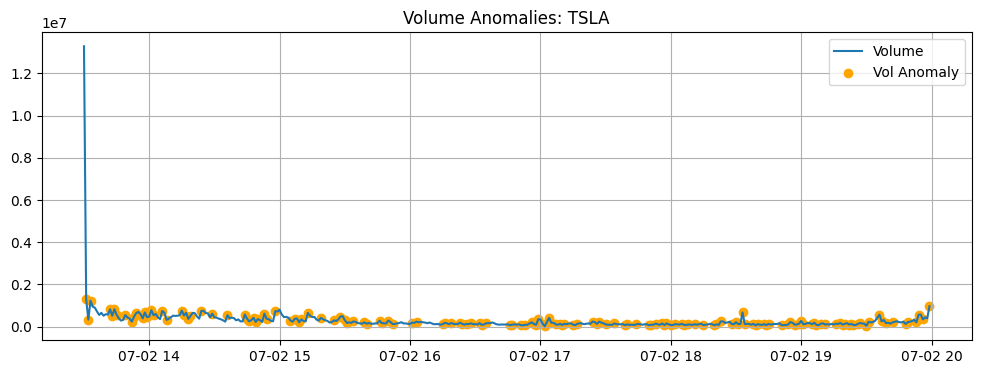

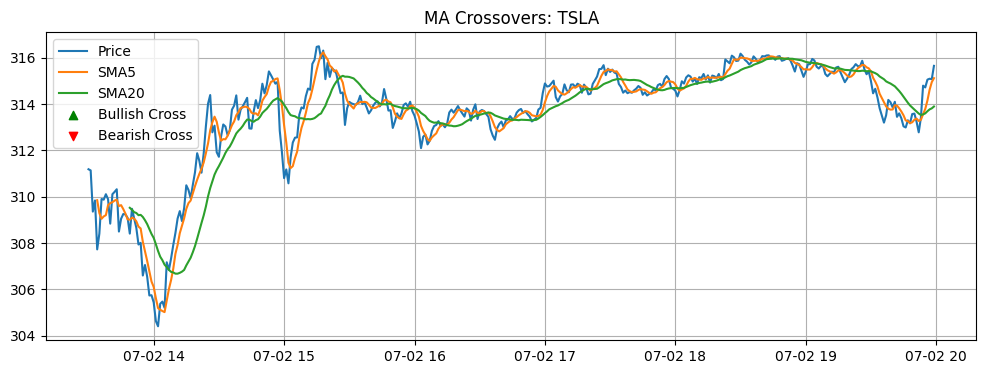

 0 combined anomalies saved to TSLA_confirmed_anomalies.csv

 Processing: MSFT
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 64, 'dropout': 0.3, 'learning_rate': 0.01, 'batch_size': 32}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
 Dynamic threshold set to 0.0007
 Max error: 0.0014, Mean error: 0.0002, Std Dev: 0.0002


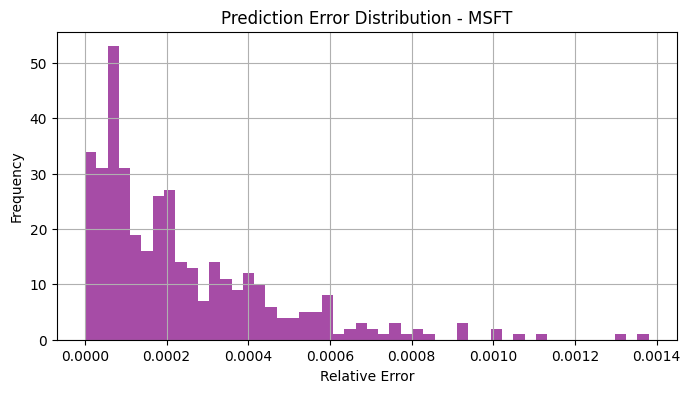

 Exported 19 LSTM anomalies to MSFT_LSTM_anomalies.csv


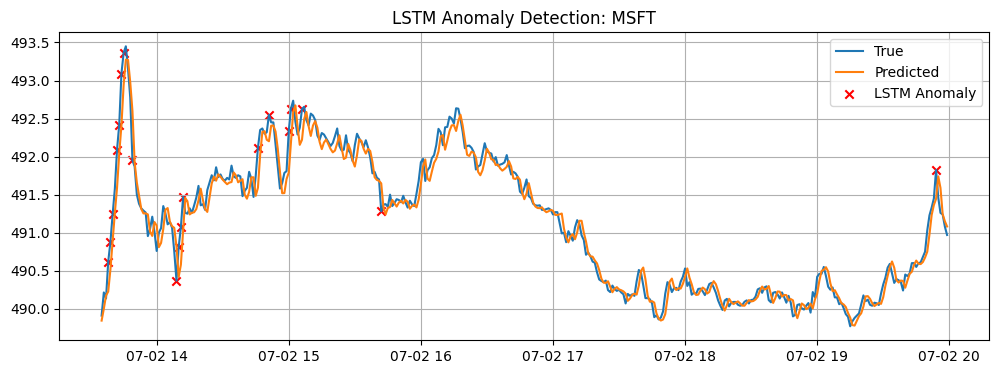

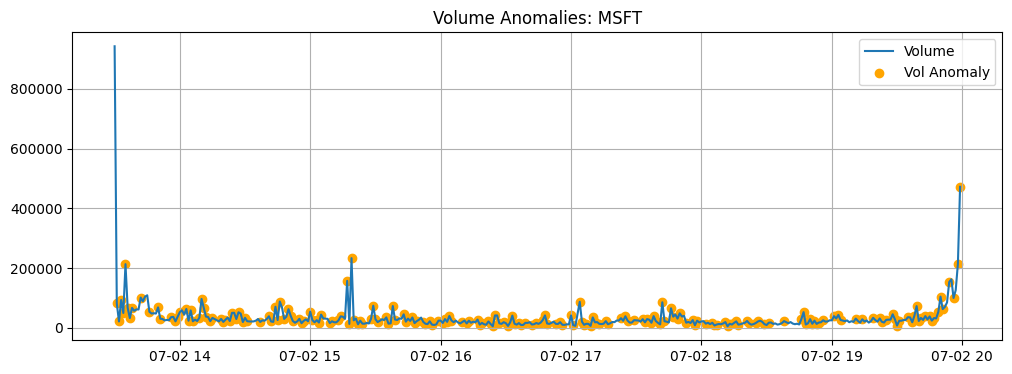

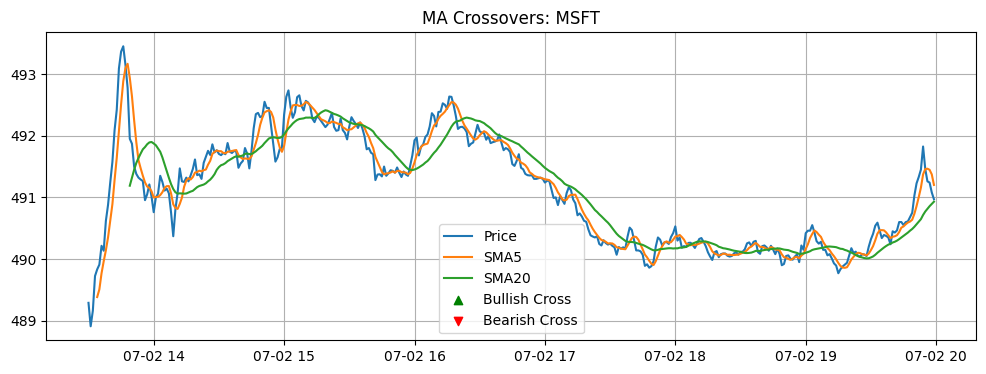

 0 combined anomalies saved to MSFT_confirmed_anomalies.csv

 Processing: NVDA
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 16, 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 8}
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
 Dynamic threshold set to 0.0018
 Max error: 0.0048, Mean error: 0.0006, Std Dev: 0.0006


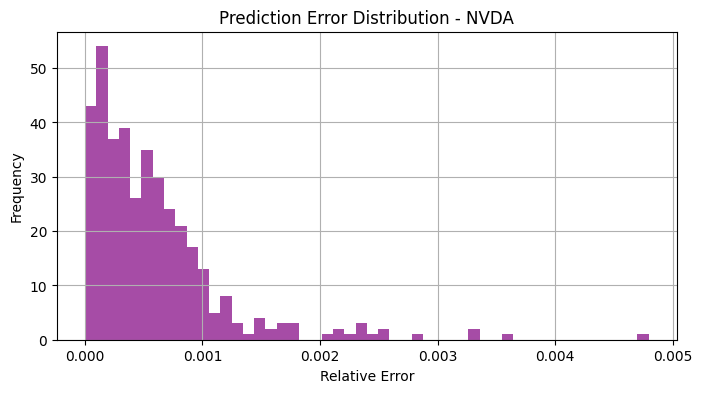

 Exported 17 LSTM anomalies to NVDA_LSTM_anomalies.csv


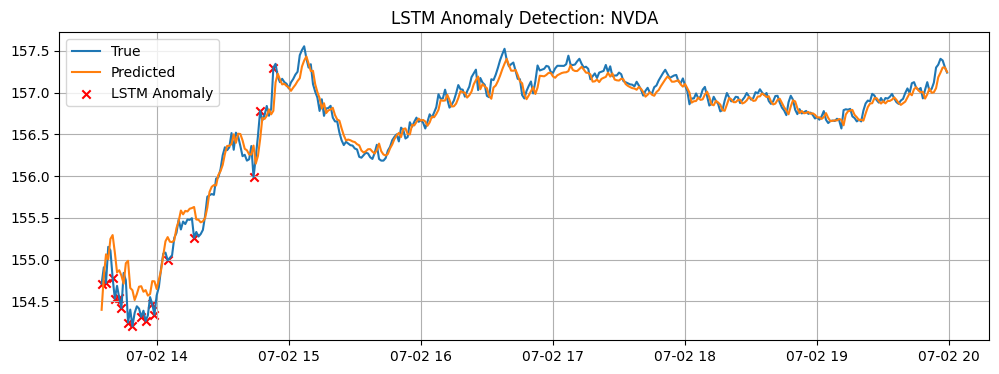

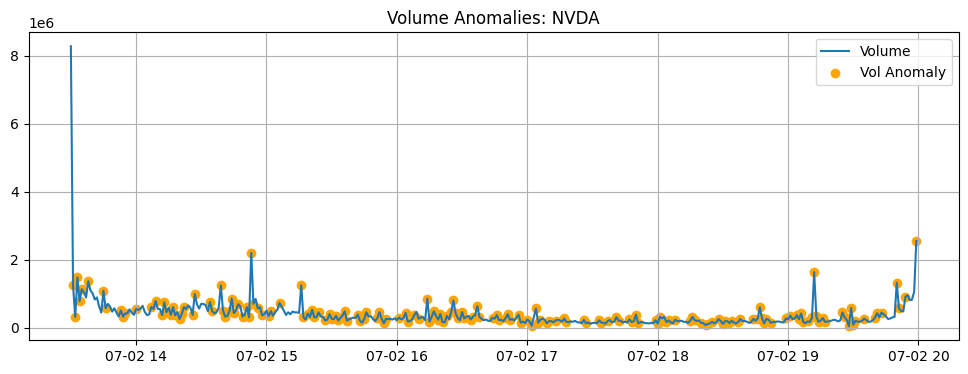

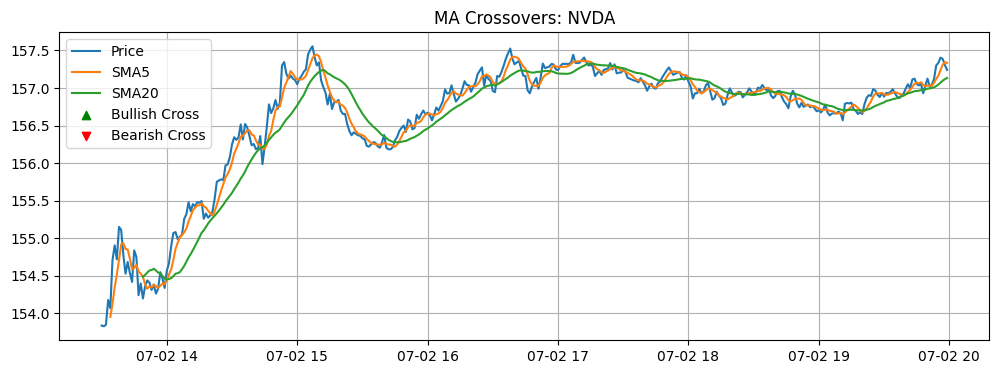

 0 combined anomalies saved to NVDA_confirmed_anomalies.csv

 Processing: COALINDIA.NS
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 32, 'dropout': 0.1, 'learning_rate': 0.01, 'batch_size': 16}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
 Dynamic threshold set to 0.0013
 Max error: 0.0020, Mean error: 0.0005, Std Dev: 0.0004


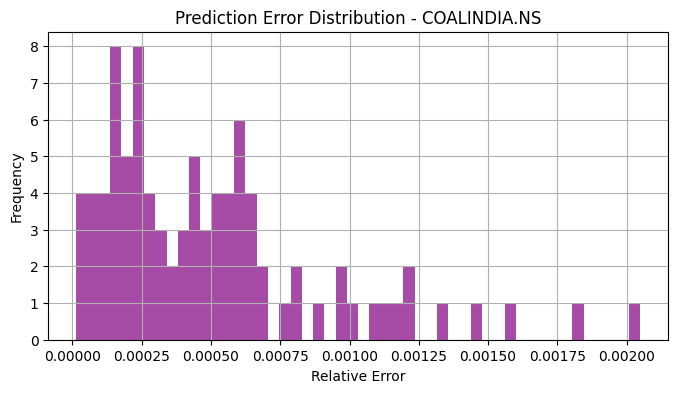

 Exported 5 LSTM anomalies to COALINDIA.NS_LSTM_anomalies.csv


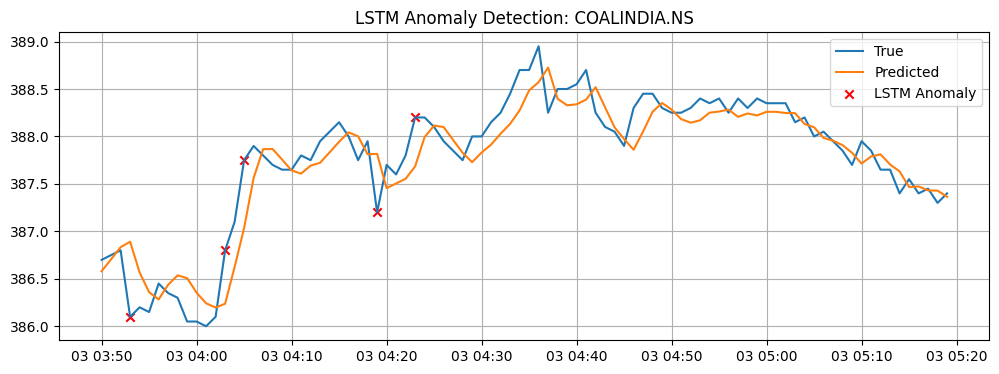

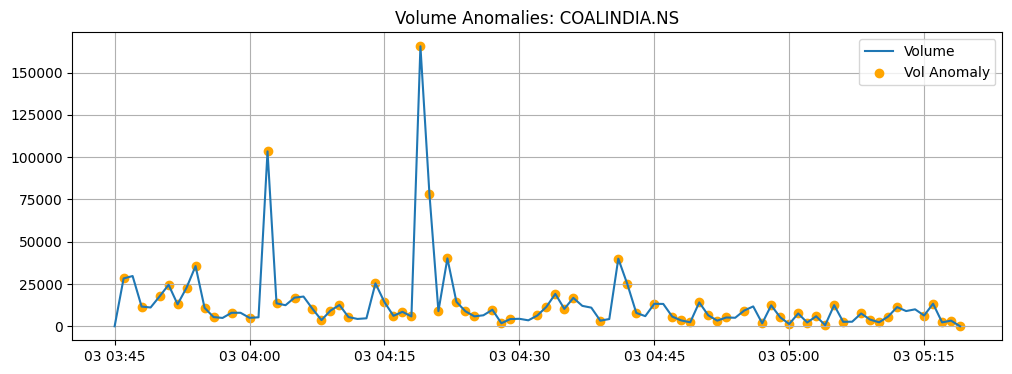

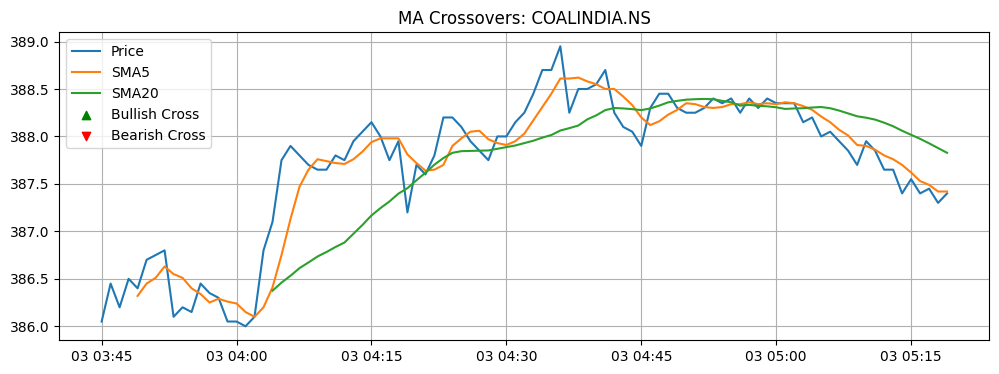

 0 combined anomalies saved to COALINDIA.NS_confirmed_anomalies.csv

 Processing: INFY.NS
🔍 Manually tuning hyperparameters...
 Best manual params: {'units': 32, 'dropout': 0.2, 'learning_rate': 0.01, 'batch_size': 8}
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
 Dynamic threshold set to 0.0013
 Max error: 0.0019, Mean error: 0.0006, Std Dev: 0.0004


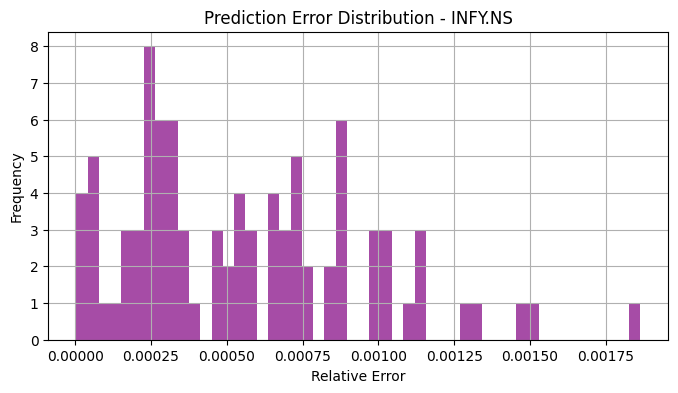

 Exported 3 LSTM anomalies to INFY.NS_LSTM_anomalies.csv


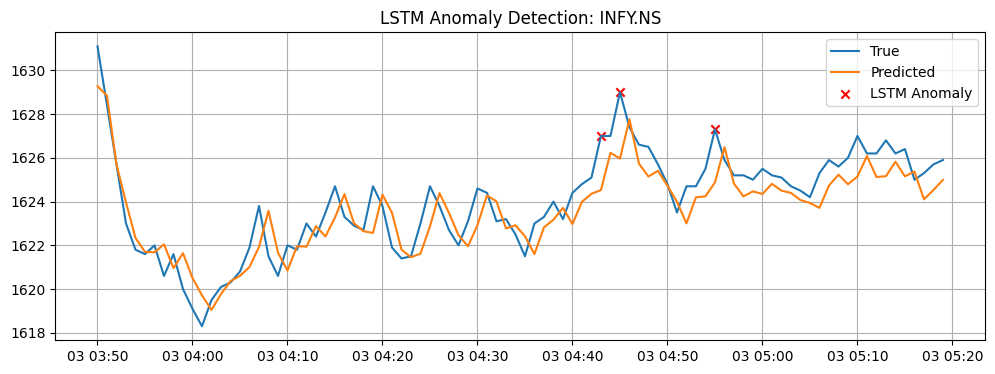

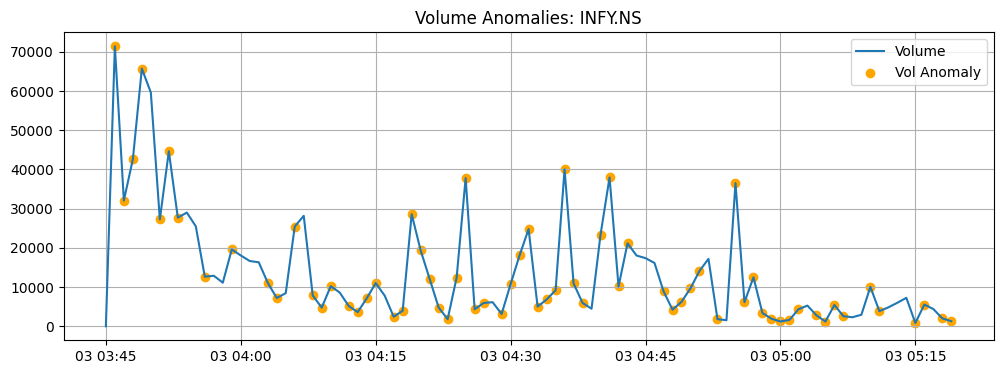

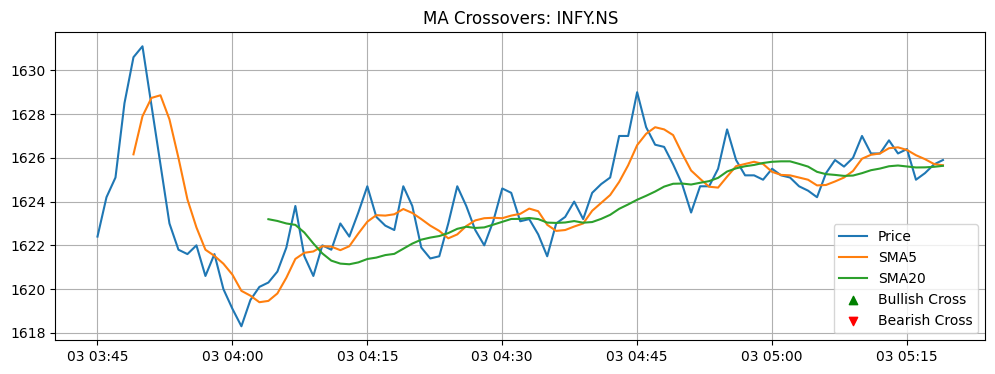

 0 combined anomalies saved to INFY.NS_confirmed_anomalies.csv


In [51]:
detect_anomalies(stock_data, stock_symbols, window_size=5)

